### Code Summary

1. **Data Loading and Preparation:**
   - The dataset is loaded, unnecessary columns (like `ID`) are removed, and the target vector is flattened.

2. **Cross-Validation:**
   - `KFold` cross-validation is used to split the dataset into training and test sets for each fold.

3. **Feature Selection:**
   - Within each fold, feature selection is performed using `mrmr_classif` on the **training set**.

4. **Model Evaluation:**
   - For each number of selected features (from 1 to 450), a Random Forest model is trained and its performance is evaluated on the test set.

5. **Metric Calculation:**
   - Metrics (accuracy, precision, recall, f1 score, specificity) are calculated and stored for each fold and each number of selected features.

6. **Metric Averaging:**
   - After all folds are completed, the average of each metric is computed for each number of selected features.

7. **Visualization:**
   - Finally, the average metrics are plotted against the number of selected features to visualize model performance.



100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:28<00:00, 15.56it/s]



Using the top 1 mRMR features:
  Accuracy: 0.6618
  Precision: 0.7124
  Recall (Sensitivity): 0.5815
  F1 Score: 0.6265
  Specificity: 0.7567

Using the top 2 mRMR features:
  Accuracy: 0.6847
  Precision: 0.7307
  Recall (Sensitivity): 0.6121
  F1 Score: 0.6558
  Specificity: 0.7683

Using the top 3 mRMR features:
  Accuracy: 0.7017
  Precision: 0.7252
  Recall (Sensitivity): 0.6916
  F1 Score: 0.6973
  Specificity: 0.7239

Using the top 4 mRMR features:
  Accuracy: 0.7361
  Precision: 0.7930
  Recall (Sensitivity): 0.6791
  F1 Score: 0.7211
  Specificity: 0.8067

Using the top 5 mRMR features:
  Accuracy: 0.7420
  Precision: 0.7952
  Recall (Sensitivity): 0.6911
  F1 Score: 0.7254
  Specificity: 0.8067

Using the top 6 mRMR features:
  Accuracy: 0.7649
  Precision: 0.8019
  Recall (Sensitivity): 0.7487
  F1 Score: 0.7617
  Specificity: 0.7956

Using the top 7 mRMR features:
  Accuracy: 0.7533
  Precision: 0.8083
  Recall (Sensitivity): 0.7009
  F1 Score: 0.7398
  Specificity: 0.8178

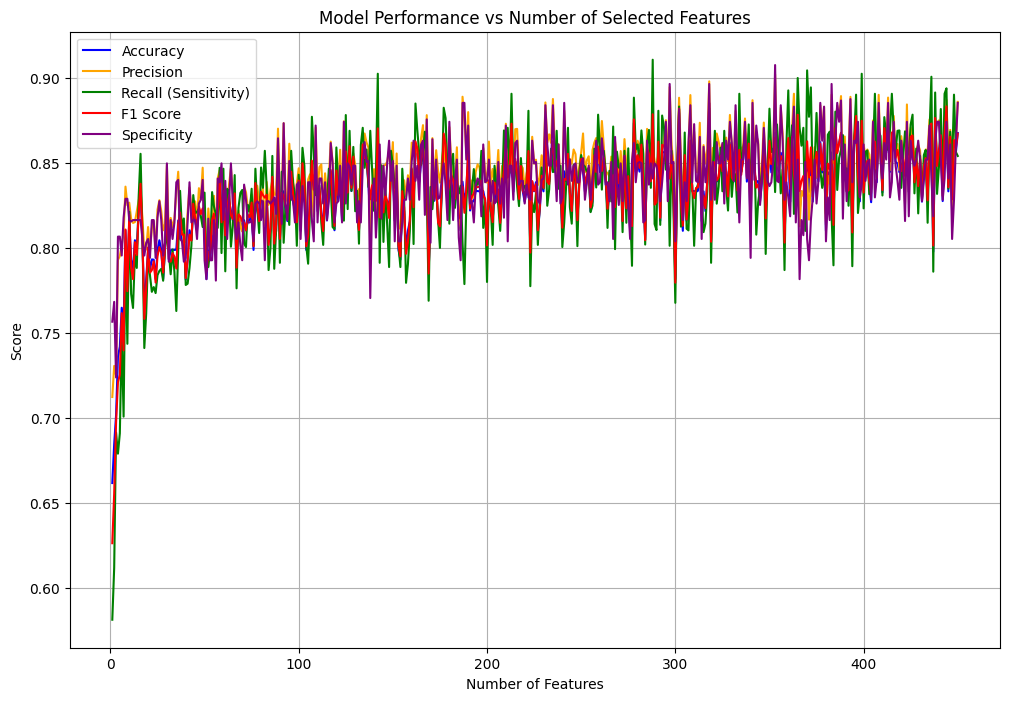

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Remove the 'ID' column
X = X.drop(columns=['ID'])

# Flatten the target vector
y = y.values.ravel()

# Define the number of splits for Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the Random Forest parameters
rf_params = {
    'bootstrap': True,
    'criterion': 'gini',
    'max_depth': 2,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 50,
    'random_state': 42
}

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Define the scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)
}

# Dictionary to save the results
results = {i: [] for i in range(1, 451)}

# Iterate over each fold of the cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply mRMR feature selection on the training set
    selected_features = mrmr_classif(X=X_train, y=y_train, K=450)
    
    # Iterate over the number of features to use (from 1 to 450)
    for n_features in range(1, 451):
        # Select the top n_features
        X_train_selected = X_train[selected_features[:n_features]]
        X_test_selected = X_test[selected_features[:n_features]]
        
        # Create a pipeline with StandardScaler and RandomForestClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),                  # Standardize the data
            ('classifier', RandomForestClassifier(**rf_params))  # Random Forest Classifier
        ])
        
        # Train the model
        pipeline.fit(X_train_selected, y_train)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate and store the metrics
        results[n_features].append({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label='P'),
            'recall': recall_score(y_test, y_pred, pos_label='P'),
            'f1': f1_score(y_test, y_pred, pos_label='P'),
            'specificity': specificity(y_test, y_pred)
        })

# Calculate average metrics for each number of features
average_results = {i: {} for i in range(1, 451)}
for n_features in range(1, 451):
    average_results[n_features] = {
        'accuracy': np.mean([r['accuracy'] for r in results[n_features]]),
        'precision': np.mean([r['precision'] for r in results[n_features]]),
        'recall': np.mean([r['recall'] for r in results[n_features]]),
        'f1': np.mean([r['f1'] for r in results[n_features]]),
        'specificity': np.mean([r['specificity'] for r in results[n_features]])
    }
    
    # Print the results for the current number of selected features
    print(f"\nUsing the top {n_features} mRMR features:")
    print(f"  Accuracy: {average_results[n_features]['accuracy']:.4f}")
    print(f"  Precision: {average_results[n_features]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {average_results[n_features]['recall']:.4f}")
    print(f"  F1 Score: {average_results[n_features]['f1']:.4f}")
    print(f"  Specificity: {average_results[n_features]['specificity']:.4f}")


# Prepare the data for plotting
num_features = list(range(1, 451))
accuracy = [average_results[n]['accuracy'] for n in num_features]
precision = [average_results[n]['precision'] for n in num_features]
recall = [average_results[n]['recall'] for n in num_features]
f1 = [average_results[n]['f1'] for n in num_features]
specificity = [average_results[n]['specificity'] for n in num_features]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(num_features, accuracy, label='Accuracy', color='blue')
plt.plot(num_features, precision, label='Precision', color='orange')
plt.plot(num_features, recall, label='Recall (Sensitivity)', color='green')
plt.plot(num_features, f1, label='F1 Score', color='red')
plt.plot(num_features, specificity, label='Specificity', color='purple')

# Add labels and title
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Selected Features')
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()



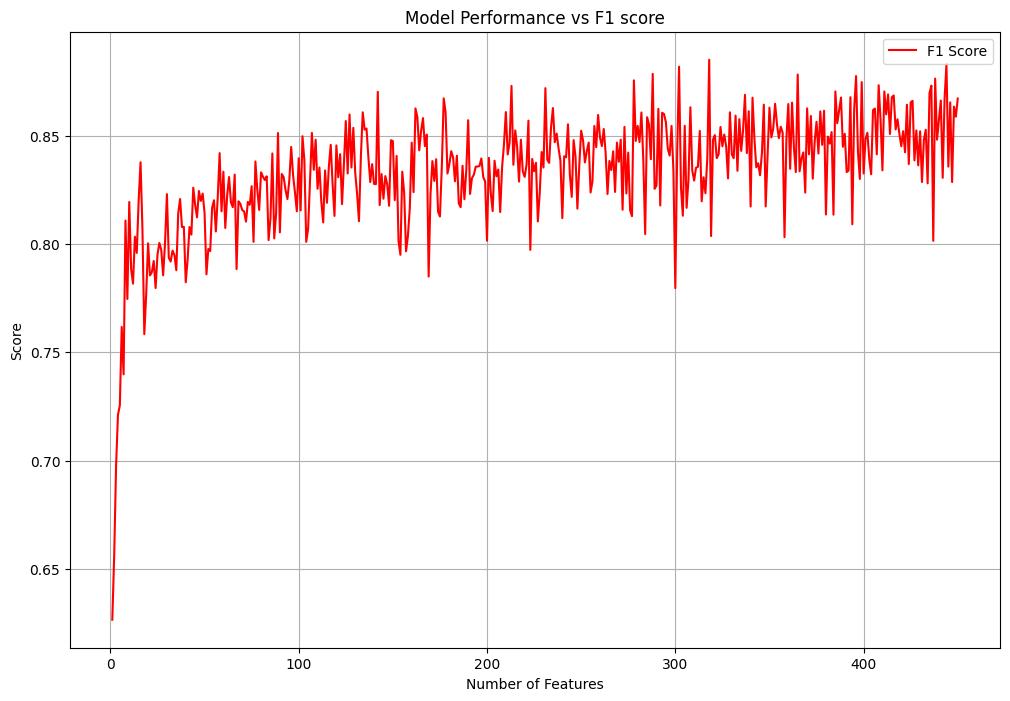

In [8]:
# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(num_features, f1, label='F1 Score', color='red')

# Add labels and title
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Model Performance vs F1 score')
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()

In [9]:
# Find the number of features that gives the maximum F1 score
max_f1_index = np.argmax(f1)  # This gives the index of the maximum F1 score
max_f1_features = num_features[max_f1_index]  # Corresponding number of features

print(f"The maximum F1 score is {f1[max_f1_index]:.4f} with {max_f1_features} features.")

# Create a list of tuples (number_of_features, f1_score) and sort them in descending order
ranked_features = sorted(zip(num_features, f1), key=lambda x: x[1], reverse=True)

# Display the top 10 configurations with the highest F1 scores
print("\nTop 10 configurations ranked by F1 score:")
for i, (n_feat, f1_score) in enumerate(ranked_features[:10], 1):
    print(f"{i}: {n_feat} features -> F1 Score: {f1_score:.4f}")


The maximum F1 score is 0.8851 with 318 features.

Top 10 configurations ranked by F1 score:
1: 318 features -> F1 Score: 0.8851
2: 444 features -> F1 Score: 0.8832
3: 302 features -> F1 Score: 0.8819
4: 288 features -> F1 Score: 0.8786
5: 365 features -> F1 Score: 0.8783
6: 396 features -> F1 Score: 0.8775
7: 438 features -> F1 Score: 0.8764
8: 278 features -> F1 Score: 0.8756
9: 399 features -> F1 Score: 0.8748
10: 408 features -> F1 Score: 0.8733


## Decision Tree

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:48<00:00,  9.35it/s]



Using the top 1 mRMR features:
  Accuracy: 0.6618
  Precision: 0.7435
  Recall (Sensitivity): 0.5499
  F1 Score: 0.6114
  Specificity: 0.7942

Using the top 2 mRMR features:
  Accuracy: 0.6618
  Precision: 0.7435
  Recall (Sensitivity): 0.5499
  F1 Score: 0.6114
  Specificity: 0.7942

Using the top 3 mRMR features:
  Accuracy: 0.6618
  Precision: 0.7435
  Recall (Sensitivity): 0.5499
  F1 Score: 0.6114
  Specificity: 0.7942

Using the top 4 mRMR features:
  Accuracy: 0.6618
  Precision: 0.7435
  Recall (Sensitivity): 0.5499
  F1 Score: 0.6114
  Specificity: 0.7942

Using the top 5 mRMR features:
  Accuracy: 0.6733
  Precision: 0.7527
  Recall (Sensitivity): 0.5852
  F1 Score: 0.6336
  Specificity: 0.7831

Using the top 6 mRMR features:
  Accuracy: 0.6676
  Precision: 0.7254
  Recall (Sensitivity): 0.6441
  F1 Score: 0.6526
  Specificity: 0.7164

Using the top 7 mRMR features:
  Accuracy: 0.6961
  Precision: 0.7981
  Recall (Sensitivity): 0.5617
  F1 Score: 0.6387
  Specificity: 0.8497

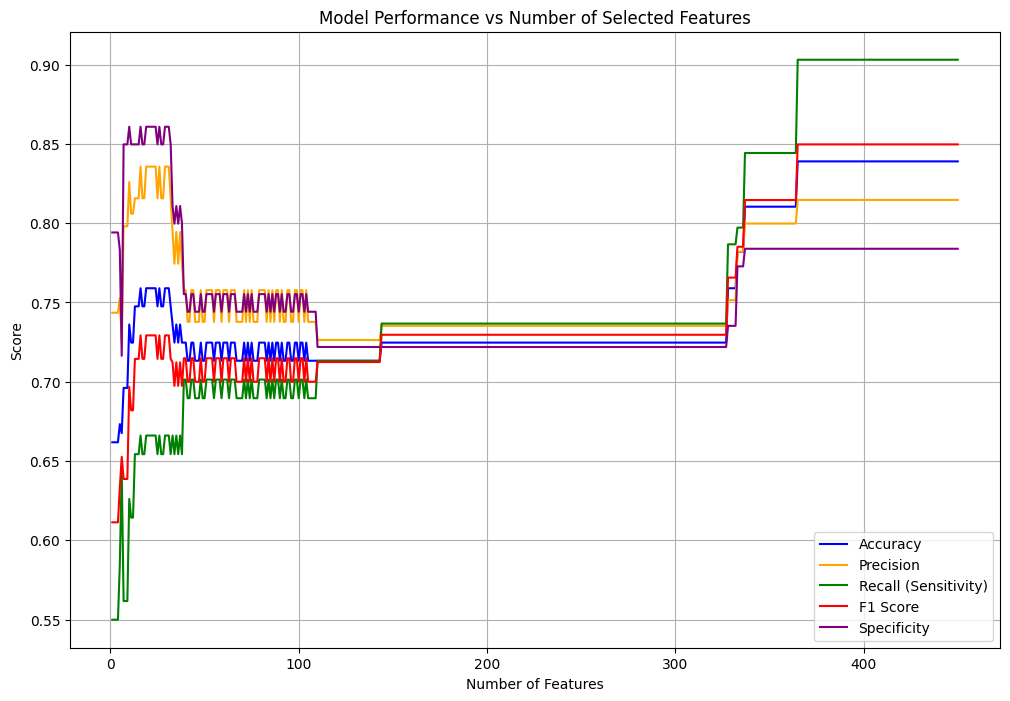

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Remove the 'ID' column
X = X.drop(columns=['ID'])

# Flatten the target vector
y = y.values.ravel()

# Define the number of splits for Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the Decision Tree parameters
dt_params = {
    'criterion': 'gini',
    'max_depth': 2,
    'max_leaf_nodes': 2,
    'min_samples_leaf': 2,
    'min_samples_split': 2
}

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Define the scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)
}

# Dictionary to save the results
results = {i: [] for i in range(1, 451)}

# Iterate over each fold of the cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply mRMR feature selection on the training set
    selected_features = mrmr_classif(X=X_train, y=y_train, K=450)
    
    # Iterate over the number of features to use (from 1 to 450)
    for n_features in range(1, 451):
        # Select the top n_features
        X_train_selected = X_train[selected_features[:n_features]]
        X_test_selected = X_test[selected_features[:n_features]]
        
        # Create a pipeline with StandardScaler and DecisionTreeClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),                  # Standardize the data
            ('classifier', DecisionTreeClassifier(**dt_params))  # Decision Tree Classifier
        ])
        
        # Train the model
        pipeline.fit(X_train_selected, y_train)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate and store the metrics
        results[n_features].append({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label='P'),
            'recall': recall_score(y_test, y_pred, pos_label='P'),
            'f1': f1_score(y_test, y_pred, pos_label='P'),
            'specificity': specificity(y_test, y_pred)
        })

# Calculate average metrics for each number of features
average_results = {i: {} for i in range(1, 451)}
for n_features in range(1, 451):
    average_results[n_features] = {
        'accuracy': np.mean([r['accuracy'] for r in results[n_features]]),
        'precision': np.mean([r['precision'] for r in results[n_features]]),
        'recall': np.mean([r['recall'] for r in results[n_features]]),
        'f1': np.mean([r['f1'] for r in results[n_features]]),
        'specificity': np.mean([r['specificity'] for r in results[n_features]])
    }
    
    # Print the results for the current number of selected features
    print(f"\nUsing the top {n_features} mRMR features:")
    print(f"  Accuracy: {average_results[n_features]['accuracy']:.4f}")
    print(f"  Precision: {average_results[n_features]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {average_results[n_features]['recall']:.4f}")
    print(f"  F1 Score: {average_results[n_features]['f1']:.4f}")
    print(f"  Specificity: {average_results[n_features]['specificity']:.4f}")


# Prepare the data for plotting
num_features = list(range(1, 451))
accuracy = [average_results[n]['accuracy'] for n in num_features]
precision = [average_results[n]['precision'] for n in num_features]
recall = [average_results[n]['recall'] for n in num_features]
f1 = [average_results[n]['f1'] for n in num_features]
specificity = [average_results[n]['specificity'] for n in num_features]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(num_features, accuracy, label='Accuracy', color='blue')
plt.plot(num_features, precision, label='Precision', color='orange')
plt.plot(num_features, recall, label='Recall (Sensitivity)', color='green')
plt.plot(num_features, f1, label='F1 Score', color='red')
plt.plot(num_features, specificity, label='Specificity', color='purple')

# Add labels and title
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Selected Features')
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()


### We have the same problem noticed with PCA, maybe, so we might want to retry this by changing the parameters of the trees

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:28<00:00, 15.99it/s]



Using the top 1 mRMR features:
  Accuracy: 0.6104
  Precision: 0.6363
  Recall (Sensitivity): 0.5574
  F1 Score: 0.5897
  Specificity: 0.6675

Using the top 2 mRMR features:
  Accuracy: 0.6736
  Precision: 0.6920
  Recall (Sensitivity): 0.6503
  F1 Score: 0.6635
  Specificity: 0.7050

Using the top 3 mRMR features:
  Accuracy: 0.6790
  Precision: 0.7051
  Recall (Sensitivity): 0.6731
  F1 Score: 0.6753
  Specificity: 0.6994

Using the top 4 mRMR features:
  Accuracy: 0.7590
  Precision: 0.7758
  Recall (Sensitivity): 0.7735
  F1 Score: 0.7625
  Specificity: 0.7594

Using the top 5 mRMR features:
  Accuracy: 0.7188
  Precision: 0.7755
  Recall (Sensitivity): 0.6707
  F1 Score: 0.7061
  Specificity: 0.7839

Using the top 6 mRMR features:
  Accuracy: 0.7415
  Precision: 0.7984
  Recall (Sensitivity): 0.6817
  F1 Score: 0.7260
  Specificity: 0.8164

Using the top 7 mRMR features:
  Accuracy: 0.7474
  Precision: 0.7946
  Recall (Sensitivity): 0.7026
  F1 Score: 0.7352
  Specificity: 0.8053

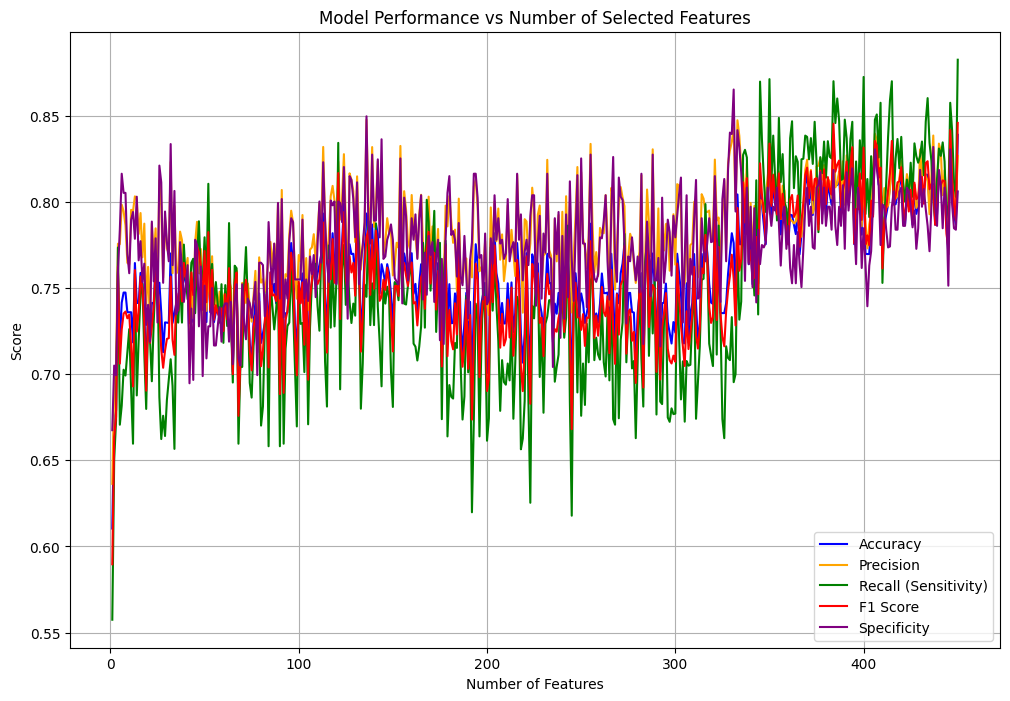

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Remove the 'ID' column
X = X.drop(columns=['ID'])

# Flatten the target vector
y = y.values.ravel()

# Define the number of splits for Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the Decision Tree parameters
dt_params = {
    'criterion': 'gini',
    'max_depth': 10,  # Increased depth
    'max_leaf_nodes': 50,  # Increased number of leaf nodes
    'min_samples_leaf': 1,  # Allow fewer samples per leaf
    'min_samples_split': 2,  # Allow splitting with fewer samples
    'random_state': 42
}

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Define the scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)
}

# Dictionary to save the results
results = {i: [] for i in range(1, 451)}

# Iterate over each fold of the cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply mRMR feature selection on the training set
    selected_features = mrmr_classif(X=X_train, y=y_train, K=450)
    
    # Iterate over the number of features to use (from 1 to 450)
    for n_features in range(1, 451):
        # Select the top n_features
        X_train_selected = X_train[selected_features[:n_features]]
        X_test_selected = X_test[selected_features[:n_features]]
        
        # Create a pipeline with StandardScaler and DecisionTreeClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),                  # Standardize the data
            ('classifier', DecisionTreeClassifier(**dt_params))  # Decision Tree Classifier
        ])
        
        # Train the model
        pipeline.fit(X_train_selected, y_train)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate and store the metrics
        results[n_features].append({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label='P'),
            'recall': recall_score(y_test, y_pred, pos_label='P'),
            'f1': f1_score(y_test, y_pred, pos_label='P'),
            'specificity': specificity(y_test, y_pred)
        })

# Calculate average metrics for each number of features
average_results = {i: {} for i in range(1, 451)}
for n_features in range(1, 451):
    average_results[n_features] = {
        'accuracy': np.mean([r['accuracy'] for r in results[n_features]]),
        'precision': np.mean([r['precision'] for r in results[n_features]]),
        'recall': np.mean([r['recall'] for r in results[n_features]]),
        'f1': np.mean([r['f1'] for r in results[n_features]]),
        'specificity': np.mean([r['specificity'] for r in results[n_features]])
    }
    
    # Print the results for the current number of selected features
    print(f"\nUsing the top {n_features} mRMR features:")
    print(f"  Accuracy: {average_results[n_features]['accuracy']:.4f}")
    print(f"  Precision: {average_results[n_features]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {average_results[n_features]['recall']:.4f}")
    print(f"  F1 Score: {average_results[n_features]['f1']:.4f}")
    print(f"  Specificity: {average_results[n_features]['specificity']:.4f}")


# Prepare the data for plotting
num_features = list(range(1, 451))
accuracy = [average_results[n]['accuracy'] for n in num_features]
precision = [average_results[n]['precision'] for n in num_features]
recall = [average_results[n]['recall'] for n in num_features]
f1 = [average_results[n]['f1'] for n in num_features]
specificity = [average_results[n]['specificity'] for n in num_features]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(num_features, accuracy, label='Accuracy', color='blue')
plt.plot(num_features, precision, label='Precision', color='orange')
plt.plot(num_features, recall, label='Recall (Sensitivity)', color='green')
plt.plot(num_features, f1, label='F1 Score', color='red')
plt.plot(num_features, specificity, label='Specificity', color='purple')

# Add labels and title
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Selected Features')
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()


In [11]:
# Find the number of features that gives the maximum F1 score
max_f1_index = np.argmax(f1)  # This gives the index of the maximum F1 score
max_f1_features = num_features[max_f1_index]  # Corresponding number of features

print(f"The maximum F1 score is {f1[max_f1_index]:.4f} with {max_f1_features} features.")

# Create a list of tuples (number_of_features, f1_score) and sort them in descending order
ranked_features = sorted(zip(num_features, f1), key=lambda x: x[1], reverse=True)

# Display the top 10 configurations with the highest F1 scores
print("\nTop 10 configurations ranked by F1 score:")
for i, (n_feat, f1_score) in enumerate(ranked_features[:10], 1):
    print(f"{i}: {n_feat} features -> F1 Score: {f1_score:.4f}")


The maximum F1 score is 0.8459 with 450 features.

Top 10 configurations ranked by F1 score:
1: 450 features -> F1 Score: 0.8459
2: 384 features -> F1 Score: 0.8454
3: 446 features -> F1 Score: 0.8418
4: 406 features -> F1 Score: 0.8354
5: 415 features -> F1 Score: 0.8354
6: 350 features -> F1 Score: 0.8339
7: 407 features -> F1 Score: 0.8326
8: 394 features -> F1 Score: 0.8318
9: 400 features -> F1 Score: 0.8316
10: 387 features -> F1 Score: 0.8240


## kNN

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:32<00:00, 13.68it/s]



Using the top 1 mRMR features:
  Accuracy: 0.6161
  Precision: 0.6403
  Recall (Sensitivity): 0.6008
  F1 Score: 0.6136
  Specificity: 0.6328

Using the top 2 mRMR features:
  Accuracy: 0.6390
  Precision: 0.6463
  Recall (Sensitivity): 0.6506
  F1 Score: 0.6468
  Specificity: 0.6208

Using the top 3 mRMR features:
  Accuracy: 0.6556
  Precision: 0.6861
  Recall (Sensitivity): 0.6113
  F1 Score: 0.6403
  Specificity: 0.7100

Using the top 4 mRMR features:
  Accuracy: 0.7018
  Precision: 0.7572
  Recall (Sensitivity): 0.6466
  F1 Score: 0.6879
  Specificity: 0.7675

Using the top 5 mRMR features:
  Accuracy: 0.7356
  Precision: 0.7931
  Recall (Sensitivity): 0.6781
  F1 Score: 0.7207
  Specificity: 0.8075

Using the top 6 mRMR features:
  Accuracy: 0.7588
  Precision: 0.8376
  Recall (Sensitivity): 0.6639
  F1 Score: 0.7368
  Specificity: 0.8631

Using the top 7 mRMR features:
  Accuracy: 0.7474
  Precision: 0.8315
  Recall (Sensitivity): 0.6416
  F1 Score: 0.7197
  Specificity: 0.8631

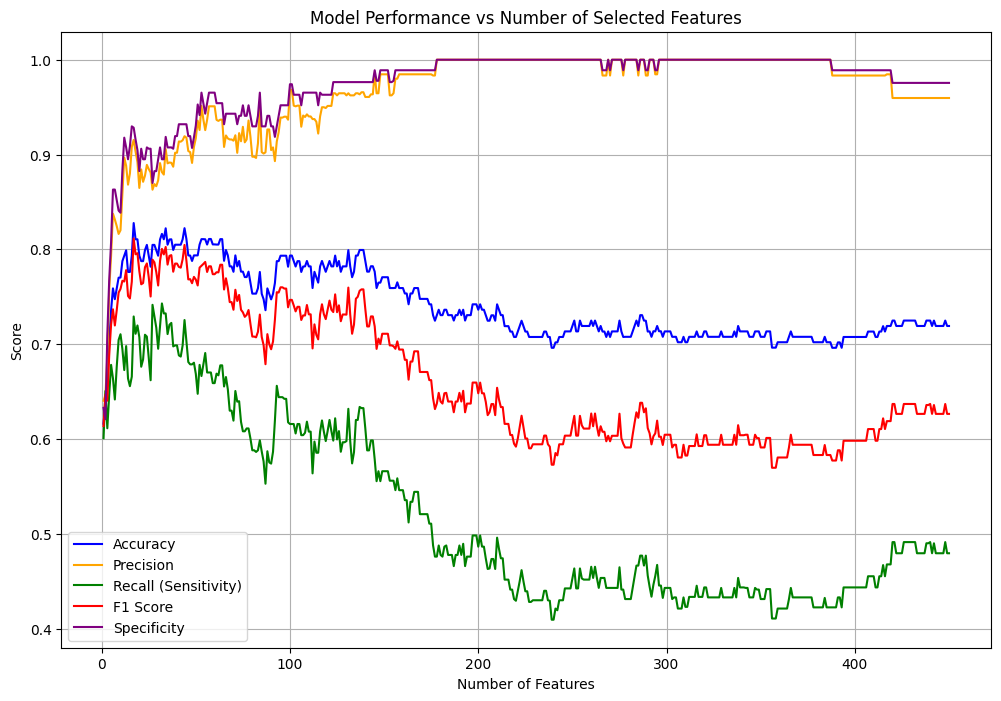

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Remove the 'ID' column
X = X.drop(columns=['ID'])

# Flatten the target vector
y = y.values.ravel()

# Define the number of splits for Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the KNN parameters
knn_params = {
    'algorithm': 'auto',
    'leaf_size': 10,
    'metric': 'minkowski',
    'metric_params': None,
    'n_neighbors': 1,
    'p': 1,
    'weights': 'uniform'
}

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Define the scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)
}

# Dictionary to save the results
results = {i: [] for i in range(1, 451)}

# Iterate over each fold of the cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply mRMR feature selection on the training set
    selected_features = mrmr_classif(X=X_train, y=y_train, K=450)
    
    # Iterate over the number of features to use (from 1 to 450)
    for n_features in range(1, 451):
        # Select the top n_features
        X_train_selected = X_train[selected_features[:n_features]]
        X_test_selected = X_test[selected_features[:n_features]]
        
        # Create a pipeline with StandardScaler and KNeighborsClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),                  # Standardize the data
            ('classifier', KNeighborsClassifier(**knn_params))  # K-Nearest Neighbors Classifier
        ])
        
        # Train the model
        pipeline.fit(X_train_selected, y_train)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate and store the metrics
        results[n_features].append({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label='P'),
            'recall': recall_score(y_test, y_pred, pos_label='P'),
            'f1': f1_score(y_test, y_pred, pos_label='P'),
            'specificity': specificity(y_test, y_pred)
        })

# Calculate average metrics for each number of features
average_results = {i: {} for i in range(1, 451)}
for n_features in range(1, 451):
    average_results[n_features] = {
        'accuracy': np.mean([r['accuracy'] for r in results[n_features]]),
        'precision': np.mean([r['precision'] for r in results[n_features]]),
        'recall': np.mean([r['recall'] for r in results[n_features]]),
        'f1': np.mean([r['f1'] for r in results[n_features]]),
        'specificity': np.mean([r['specificity'] for r in results[n_features]])
    }
    
    # Print the results for the current number of selected features
    print(f"\nUsing the top {n_features} mRMR features:")
    print(f"  Accuracy: {average_results[n_features]['accuracy']:.4f}")
    print(f"  Precision: {average_results[n_features]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {average_results[n_features]['recall']:.4f}")
    print(f"  F1 Score: {average_results[n_features]['f1']:.4f}")
    print(f"  Specificity: {average_results[n_features]['specificity']:.4f}")

# Prepare the data for plotting
num_features = list(range(1, 451))
accuracy = [average_results[n]['accuracy'] for n in num_features]
precision = [average_results[n]['precision'] for n in num_features]
recall = [average_results[n]['recall'] for n in num_features]
f1 = [average_results[n]['f1'] for n in num_features]
specificity = [average_results[n]['specificity'] for n in num_features]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(num_features, accuracy, label='Accuracy', color='blue')
plt.plot(num_features, precision, label='Precision', color='orange')
plt.plot(num_features, recall, label='Recall (Sensitivity)', color='green')
plt.plot(num_features, f1, label='F1 Score', color='red')
plt.plot(num_features, specificity, label='Specificity', color='purple')

# Add labels and title
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Selected Features')
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()


In [7]:
# Find the number of features that gives the maximum F1 score
max_f1_index = np.argmax(f1)  # This gives the index of the maximum F1 score
max_f1_features = num_features[max_f1_index]  # Corresponding number of features

print(f"The maximum F1 score is {f1[max_f1_index]:.4f} with {max_f1_features} features.")

# Create a list of tuples (number_of_features, f1_score) and sort them in descending order
ranked_features = sorted(zip(num_features, f1), key=lambda x: x[1], reverse=True)

# Display the top 10 configurations with the highest F1 scores
print("\nTop 10 configurations ranked by F1 score:")
for i, (n_feat, f1_score) in enumerate(ranked_features[:50], 1):
    print(f"{i}: {n_feat} features -> F1 Score: {f1_score:.4f}")


The maximum F1 score is 0.8114 with 17 features.

Top 10 configurations ranked by F1 score:
1: 17 features -> F1 Score: 0.8114
2: 44 features -> F1 Score: 0.8047
3: 34 features -> F1 Score: 0.8025
4: 32 features -> F1 Score: 0.8005
5: 19 features -> F1 Score: 0.7959
6: 18 features -> F1 Score: 0.7948
7: 33 features -> F1 Score: 0.7946
8: 37 features -> F1 Score: 0.7939
9: 36 features -> F1 Score: 0.7931
10: 43 features -> F1 Score: 0.7895
11: 27 features -> F1 Score: 0.7891
12: 45 features -> F1 Score: 0.7882
13: 31 features -> F1 Score: 0.7877
14: 55 features -> F1 Score: 0.7867
15: 28 features -> F1 Score: 0.7863
16: 24 features -> F1 Score: 0.7851
17: 39 features -> F1 Score: 0.7850
18: 40 features -> F1 Score: 0.7850
19: 54 features -> F1 Score: 0.7846
20: 35 features -> F1 Score: 0.7839
21: 63 features -> F1 Score: 0.7838
22: 64 features -> F1 Score: 0.7838
23: 53 features -> F1 Score: 0.7827
24: 57 features -> F1 Score: 0.7821
25: 58 features -> F1 Score: 0.7821
26: 41 features -

## GNB

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:32<00:00, 13.83it/s]



Using the top 1 mRMR features:
  Accuracy: 0.6442
  Precision: 0.7765
  Recall (Sensitivity): 0.5287
  F1 Score: 0.5898
  Specificity: 0.7875

Using the top 2 mRMR features:
  Accuracy: 0.6615
  Precision: 0.7892
  Recall (Sensitivity): 0.5941
  F1 Score: 0.6359
  Specificity: 0.7556

Using the top 3 mRMR features:
  Accuracy: 0.6844
  Precision: 0.7781
  Recall (Sensitivity): 0.6481
  F1 Score: 0.6765
  Specificity: 0.7431

Using the top 4 mRMR features:
  Accuracy: 0.6783
  Precision: 0.7647
  Recall (Sensitivity): 0.6436
  F1 Score: 0.6718
  Specificity: 0.7319

Using the top 5 mRMR features:
  Accuracy: 0.6783
  Precision: 0.7576
  Recall (Sensitivity): 0.6226
  F1 Score: 0.6605
  Specificity: 0.7519

Using the top 6 mRMR features:
  Accuracy: 0.7071
  Precision: 0.7850
  Recall (Sensitivity): 0.6669
  F1 Score: 0.6981
  Specificity: 0.7622

Using the top 7 mRMR features:
  Accuracy: 0.7358
  Precision: 0.7916
  Recall (Sensitivity): 0.7129
  F1 Score: 0.7325
  Specificity: 0.7733

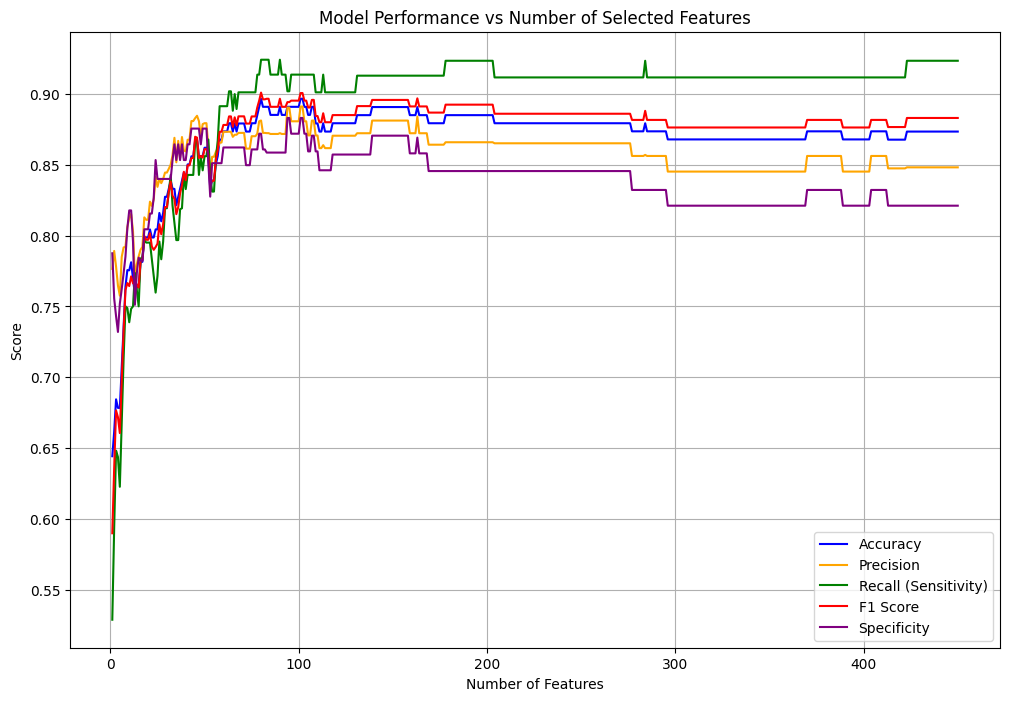

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Remove the 'ID' column
X = X.drop(columns=['ID'])

# Flatten the target vector
y = y.values.ravel()

# Define the number of splits for Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the GNB parameters
gnb_params = {
    'var_smoothing': 1e-09
}

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Define the scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)
}

# Dictionary to save the results
results = {i: [] for i in range(1, 451)}

# Iterate over each fold of the cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply mRMR feature selection on the training set
    selected_features = mrmr_classif(X=X_train, y=y_train, K=450)
    
    # Iterate over the number of features to use (from 1 to 450)
    for n_features in range(1, 451):
        # Select the top n_features
        X_train_selected = X_train[selected_features[:n_features]]
        X_test_selected = X_test[selected_features[:n_features]]
        
        # Create a pipeline with StandardScaler and GaussianNB
        pipeline = Pipeline([
            ('scaler', StandardScaler()),                  # Standardize the data
            ('classifier', GaussianNB(**gnb_params))  # Gaussian Naive Bayes Classifier
        ])
        
        # Train the model
        pipeline.fit(X_train_selected, y_train)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate and store the metrics
        results[n_features].append({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label='P'),
            'recall': recall_score(y_test, y_pred, pos_label='P'),
            'f1': f1_score(y_test, y_pred, pos_label='P'),
            'specificity': specificity(y_test, y_pred)
        })

# Calculate average metrics for each number of features
average_results = {i: {} for i in range(1, 451)}
for n_features in range(1, 451):
    average_results[n_features] = {
        'accuracy': np.mean([r['accuracy'] for r in results[n_features]]),
        'precision': np.mean([r['precision'] for r in results[n_features]]),
        'recall': np.mean([r['recall'] for r in results[n_features]]),
        'f1': np.mean([r['f1'] for r in results[n_features]]),
        'specificity': np.mean([r['specificity'] for r in results[n_features]])
    }
    
    # Print the results for the current number of selected features
    print(f"\nUsing the top {n_features} mRMR features:")
    print(f"  Accuracy: {average_results[n_features]['accuracy']:.4f}")
    print(f"  Precision: {average_results[n_features]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {average_results[n_features]['recall']:.4f}")
    print(f"  F1 Score: {average_results[n_features]['f1']:.4f}")
    print(f"  Specificity: {average_results[n_features]['specificity']:.4f}")

# Prepare the data for plotting
num_features = list(range(1, 451))
accuracy = [average_results[n]['accuracy'] for n in num_features]
precision = [average_results[n]['precision'] for n in num_features]
recall = [average_results[n]['recall'] for n in num_features]
f1 = [average_results[n]['f1'] for n in num_features]
specificity = [average_results[n]['specificity'] for n in num_features]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(num_features, accuracy, label='Accuracy', color='blue')
plt.plot(num_features, precision, label='Precision', color='orange')
plt.plot(num_features, recall, label='Recall (Sensitivity)', color='green')
plt.plot(num_features, f1, label='F1 Score', color='red')
plt.plot(num_features, specificity, label='Specificity', color='purple')

# Add labels and title
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Selected Features')
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()


In [9]:
# Find the number of features that gives the maximum F1 score
max_f1_index = np.argmax(f1)  # This gives the index of the maximum F1 score
max_f1_features = num_features[max_f1_index]  # Corresponding number of features

print(f"The maximum F1 score is {f1[max_f1_index]:.4f} with {max_f1_features} features.")

# Create a list of tuples (number_of_features, f1_score) and sort them in descending order
ranked_features = sorted(zip(num_features, f1), key=lambda x: x[1], reverse=True)

# Display the top 10 configurations with the highest F1 scores
print("\nTop 10 configurations ranked by F1 score:")
for i, (n_feat, f1_score) in enumerate(ranked_features[:10], 1):
    print(f"{i}: {n_feat} features -> F1 Score: {f1_score:.4f}")


The maximum F1 score is 0.9010 with 80 features.

Top 10 configurations ranked by F1 score:
1: 80 features -> F1 Score: 0.9010
2: 101 features -> F1 Score: 0.9007
3: 102 features -> F1 Score: 0.9007
4: 163 features -> F1 Score: 0.8969
5: 83 features -> F1 Score: 0.8966
6: 84 features -> F1 Score: 0.8966
7: 90 features -> F1 Score: 0.8966
8: 81 features -> F1 Score: 0.8962
9: 82 features -> F1 Score: 0.8962
10: 107 features -> F1 Score: 0.8958
